# Dynamic Bayesian Optimization: 
- Sina Dabiri 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, U1, X1, ker_BaO):
         # create simple GP model
        trained_model_BaO = GPy.models.GPRegression(U1,X1,ker_BaO)
        trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
        
        return trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
print('Sum preStim gamma are: \n', X0_psd, '\n','freq and amplitude used are: \n', U1[0:4])

Sum preStim gamma are: 
      sum_preStim_gamma
0             3.266571
1             2.425945
2             3.117866
3             2.868627
4             3.521665
..                 ...
379           1.268502
380           1.239859
381           1.880050
382           1.199899
383           1.343332

[384 rows x 1 columns] 
 freq and amplitude used are: 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [7]:
U1.loc[0:10, 'Stim_1']

0     17
1     42
2     35
3     23
4     42
5     35
6     11
7      7
8     17
9     11
10    17
Name: Stim_1, dtype: int64

In [8]:
print(np.shape(U1), np.shape(X0_psd))

(384, 2) (384, 1)


In [9]:
n_burn_in = 20
n_samples= 150
n_acquisition = 50

## 1.2 First BaO Model is trained on all of the dataset

In [10]:
ker_BaO = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [11]:
slice_dim = 1
ylabel='Predicted Gamma'

 C:\Users\sinad\anaconda3\envs\NeuroGaussianProcess\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22be8102e80>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22be8102d00>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s19  0005   1.624593e+03   4.779714e+03 
    01s21  0034   1.115247e+03   6.434336e-10 
Runtime:     01s21
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x22be844ebe0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22be843a760>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22be8cd6b20>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22be8ce70a0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x22be8ce70d0>]}

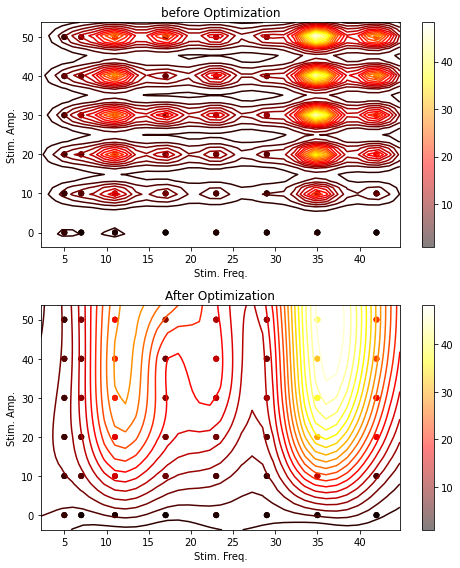

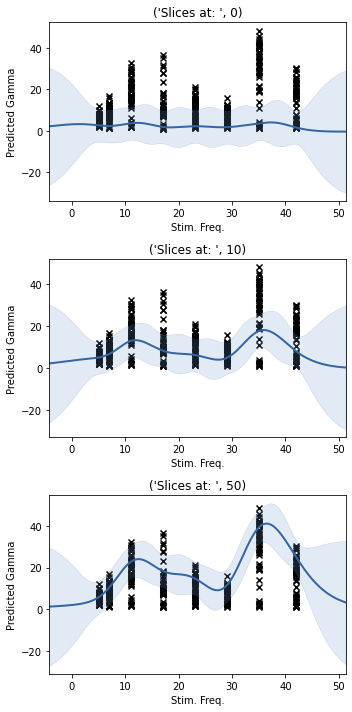

In [12]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

## 1.3: Train the second model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp/PreStimGamma 

- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [13]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:n_burn_in-1,:]
X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1[0:n_burn_in,:]
print('Sum preStim gamma are: \n', X0_psd_init, '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))

Sum preStim gamma are: 
     sum_preStim_gamma
0            3.266571
1            2.425945
2            3.117866
3            2.868627
4            3.521665
5            1.384478
6            1.420178
7            1.533292
8            2.019014
9            2.231953
10           2.347957
11           2.131811
12           1.934441
13           2.512154
14           4.690816
15           2.645199
16           6.401632
17           1.984354
18           3.580944
19           2.032816 
 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [

In [14]:
# input_data
U1_X0_init = U1_init.join(X0_psd_init)

In [15]:
print(type(U1_init),type(X1_init),type(X0_psd_init) )

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


In [16]:
ker_BaO_AF = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

#### 1.3.1: initial training

 C:\Users\sinad\anaconda3\envs\NeuroGaussianProcess\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22beae02d60>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22beaddccd0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   9.611651e+02   4.064185e+04 
    00s02  0004   4.852573e+02   3.345151e+03 
    00s04  0006   2.717979e+02   2.868045e+02 
    00s07  0011   8.975792e+01   2.859550e-01 
    00s09  0015   7.852118e+01   2.586189e-03 
    00s19  0034   7.028159e+01   9.196524e-03 
    00s22  0053   6.946105e+01   2.090537e-10 
Runtime:     00s22
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x22beb4a9b80>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22beb493a00>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22beb649250>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22beb649790>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x22beb6497c0>]}

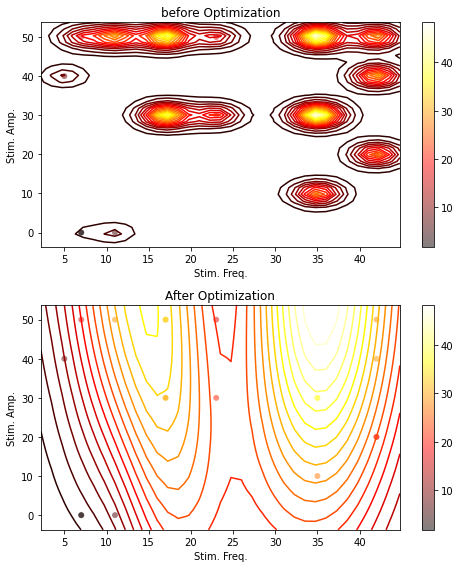

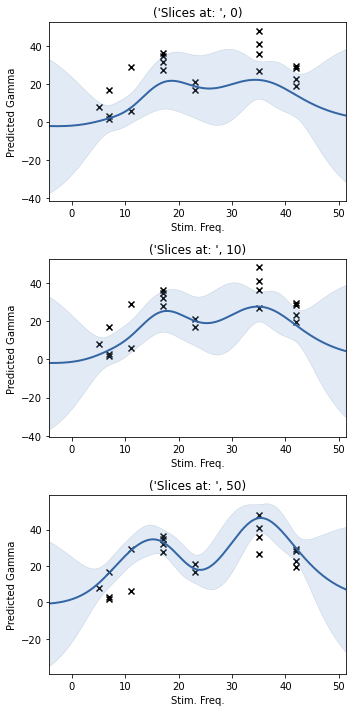

In [17]:
x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO_AF, slice_dim, ylabel)

#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [18]:
rand_freq_1d = np.random.choice(np.arange(1,43,1), size=(n_samples))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted)
rand_amp_1d = np.random.choice(np.arange(1,51,1), size=(n_samples))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))

[ 1  1  1  1  2  2  2  2  3  3  3  3  3  3  4  5  5  5  5  5  6  6  6  7
  7  7  9  9 11 11 11 11 11 12 12 13 14 14 14 14 15 15 15 15 15 16 16 16
 16 17 17 18 18 19 19 19 19 19 20 21 21 22 22 22 22 22 22 23 23 23 23 23
 23 24 24 24 24 24 25 25 25 25 26 26 26 26 27 27 27 28 28 28 29 29 30 30
 30 31 31 31 31 31 31 31 32 33 33 33 33 35 35 35 35 35 36 36 37 37 37 37
 37 37 37 38 38 38 38 38 38 38 38 38 38 39 39 39 39 39 39 40 40 41 41 41
 41 42 42 42 42 42]
[ 1  2  4  4  4  5  5  6  7  7  7  7  7  9  9  9  9  9 10 10 10 10 11 11
 11 12 13 13 13 13 14 14 14 15 15 15 15 15 16 16 16 17 17 17 18 18 18 18
 18 19 20 20 20 20 20 21 22 22 22 23 23 23 23 24 24 24 24 25 26 26 27 27
 27 28 28 28 30 30 30 31 31 31 31 31 32 32 33 33 34 35 35 35 35 35 36 36
 36 37 37 38 38 39 39 39 39 39 39 40 40 40 40 41 41 42 42 42 42 42 43 43
 43 44 44 44 44 44 45 45 45 45 46 46 46 46 47 47 47 47 47 48 48 48 49 49
 49 49 49 49 49 49] (150,)


In [19]:
# sample mean preStimGamma: for the Static BaO we just use the mean preStim Gamma
mean_preStimGamma = np.empty((n_samples,))
mean_preStimGamma[:] = np.mean(X0_psd, axis=0)
print(mean_preStimGamma[0], np.shape(mean_preStimGamma))

2.171337907722562 (150,)


In [20]:
print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted, mean_preStimGamma])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(np.shape(testX))

(150,) (150,)
(3, 150)
(150, 3)


In [21]:
# a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
ucb = np.empty((1, n_samples))
ucb_sample = np.empty((n_acquisition, 3))
postStimGamma_predicted_from_firstModel = np.empty((n_acquisition, 1))
print(np.shape(ucb))

nu = 0.1
print("nu set at: ", nu)

for a in range(1, n_acquisition):
    simY_BaO_AF = np.empty((1, n_samples))
    simMse_BaO_AF = np.empty((1, n_samples))
    simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);
    
    ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
    max_ucb = np.max(ucb, axis=0)
    argMax_ucb = ucb.argmax()

    # find the values of argMax_ucb in the sample grid
    ucb_sample[a,:] = testX[argMax_ucb]
    ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,3))
    
    # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
    postStimGamma_predicted_from_firstModel[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
    # simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);
    
    # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
    next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
    U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

    # sum_preStim_gamma
    next_preStimGamma = pd.DataFrame({'sum_preStim_gamma':[mean_preStimGamma[0]]})
    X0_psd_init = pd.concat([X0_psd_init, next_preStimGamma], ignore_index=True, axis=0)
    
    # Concatenate the first model predicted postStimGamma 
    next_postStimGamma = np.empty((1,1))
    next_postStimGamma[0,:] = [postStimGamma_predicted_from_firstModel[a]]
    X1_init = np.append(X1_init, next_postStimGamma, axis=0)
    
    # trained_model_BaO_AF.add_observer()
    # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
    trained_model_BaO_AF = model.bayes_opt_update_state(U1_init, X1_init, ker_BaO_AF)
    
    

(1, 150)
nu set at:  0.1
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0004   7.318793e+01   1.182421e-03 
    00s09  0014   7.317293e+01   3.153438e-09 
    00s11  0016   7.317293e+01   2.639607e-09 
Runtime:     00s11
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0005   7.884644e+01   2.368691e-03 
    00s08  0012   7.879080e+01   2.598670e-06    00s07  0011   7.879272e+01   1.244715e-04 
    00s16  0024   7.878983e+01   1.588371e-11 
Runtime:     00s16
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   8.237852e+01           nan 
    00s02  0003   8.238570e+01   1.889775e-02 
    00s05  0008   8.234675e+01   1.350242e-05 
    00s08  0012   8.234385e+01   2.602904e-06 
    00s15  0023   8.233314e+01   2.818689e-11    00s14  0021   8.233314e+01   6.488

#### 1.3.3: Plot before and after optimization 

Text(0, 0.5, 'postStim Gamma')

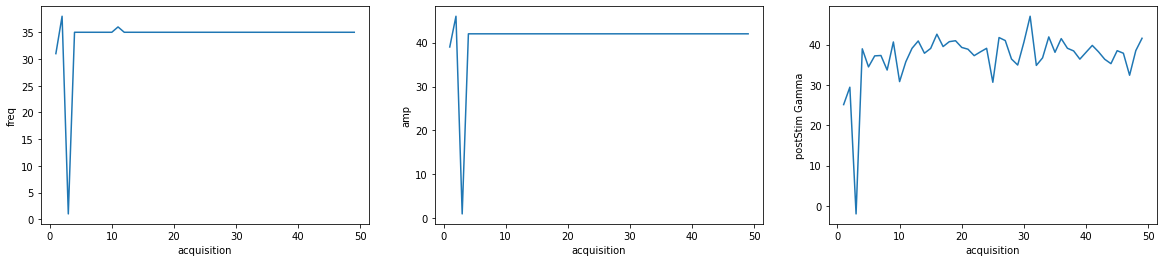

In [22]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(1,50), ucb_sample[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")

plt.subplot(1,3,2)
plt.plot(np.arange(1,50), ucb_sample[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")

plt.subplot(1,3,3)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")

# plot the model's max (freq, amp, postStim gamma) at each iteration

In [23]:
print(ucb_sample)
print(ucb_sample[1:,0])
print(ucb_sample[1:,1])


[[6.95244266e-310 6.95244267e-310 1.17933178e-311]
 [3.10000000e+001 3.90000000e+001 2.17133791e+000]
 [3.80000000e+001 4.60000000e+001 2.17133791e+000]
 [1.00000000e+000 1.00000000e+000 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.60000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+001 2.17133791e+000]
 [3.50000000e+001 4.20000000e+0

In [24]:
print(postStimGamma_predicted_from_firstModel[1:])

[[25.11769595]
 [29.43326635]
 [-1.98788256]
 [38.95382419]
 [34.47162639]
 [37.205529  ]
 [37.29658475]
 [33.68948914]
 [40.65098653]
 [30.82071431]
 [35.72616906]
 [39.07222761]
 [40.90259039]
 [37.85898933]
 [39.05149287]
 [42.57501659]
 [39.51344986]
 [40.72836833]
 [40.95820988]
 [39.29610784]
 [38.85590134]
 [37.25630084]
 [38.19549505]
 [39.07880132]
 [30.65648844]
 [41.74712252]
 [41.00244759]
 [36.43179039]
 [34.92982241]
 [40.61059623]
 [47.03054271]
 [34.83709283]
 [36.70967251]
 [41.90795487]
 [38.08815898]
 [41.48607726]
 [39.0901774 ]
 [38.42997   ]
 [36.39135202]
 [38.10336332]
 [39.79736101]
 [38.21017546]
 [36.36128461]
 [35.27289628]
 [38.48891971]
 [37.85873996]
 [32.39883412]
 [38.50906648]
 [41.56786701]]


### 1.4: Dynamic BaO

In [25]:
dynamic_model = state_dr_gp()

In [26]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_dynamic, X1_dynamic, lower_bound, upper_bound, X0_psd_dynamic, N_trials = dynamic_model.gp_model(path)

#### 1.4.1: We will not use preStimGamma, and instead we will train on most recent 20 samples so the model is not affected by brain state changes.

In [27]:
U1_init_dynamic = U1_dynamic.loc[0:n_burn_in-1,:]
X1_init_dynamic = X1_dynamic[0:n_burn_in,:]
X0_psd_init_dynamic = X0_psd_dynamic.loc[0:n_burn_in-1]

print('freq and amplitude used are: \n', U1_init_dynamic, np.shape(U1_init_dynamic))
print('Sum preStim gamma are: \n', X0_psd_init_dynamic)
print('sum postStim gamma are: \n', X1_init_dynamic, np.shape(X1_init_dynamic))

freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
Sum preStim gamma are: 
     sum_preStim_gamma
0            3.266571
1            2.425945
2            3.117866
3            2.868627
4            3.521665
5            1.384478
6            1.420178
7            1.533292
8            2.019014
9            2.231953
10           2.347957
11           2.131811
12           1.934441
13           2.512154
14           4.690816
15           2.645199
16           6.401632
17           1.984354
18           3.580944
19           2.032816
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16

In [28]:
testX_Dynamic_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted, mean_preStimGamma])
print(np.shape(testX_Dynamic_BaO))
testX_Dynamic = np.transpose(testX_Dynamic_BaO)
print(np.shape(testX_Dynamic))

(3, 150)
(150, 3)


In [29]:
ker_BaO_dynamic = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [30]:
print(np.shape(U1_init_dynamic))
print(np.shape(X1_init_dynamic))
print(np.shape(X0_psd_init_dynamic))

(20, 2)
(20, 1)
(20, 1)


In [31]:
print(type(U1_init_dynamic),type(X1_init_dynamic),type(X0_psd_init_dynamic) )

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


#### 1.4.2: Initial training of the Dynamic model

 C:\Users\sinad\anaconda3\envs\NeuroGaussianProcess\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22beb946700>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22beb7f54f0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0003   6.650130e+02   1.070147e+04 
    00s07  0011   8.975792e+01   2.859550e-01 
    00s11  0018   8.118734e+01   1.824522e-04 
    00s19  0034   7.028159e+01   9.196524e-03 
    00s23  0053   6.946105e+01   2.090537e-10 
Runtime:     00s23
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x22beadcbb50>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22beadd5b80>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22be8d610d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22be8d00e20>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x22be8d009d0>]}

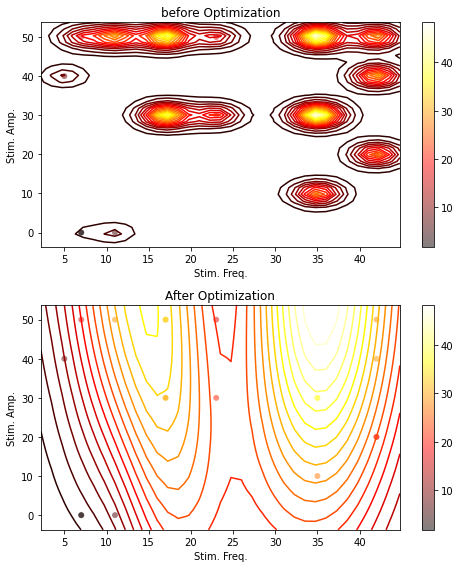

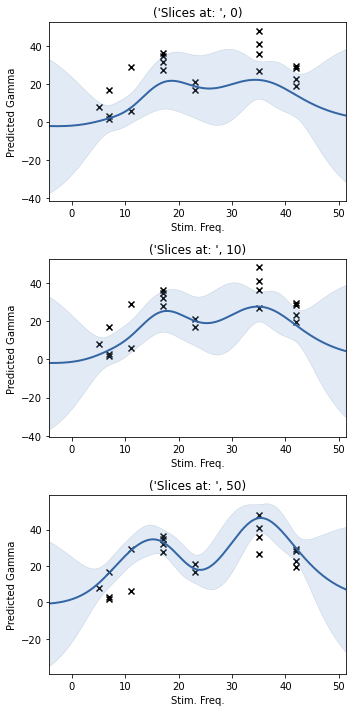

In [32]:
# Initialize a dynamic model:
x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
                                                                                               ker_BaO_dynamic, slice_dim, ylabel)
# trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
# trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);

# figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
# canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
#                         title='After Optimization');
# display(canvas)
# ax = plt.gca()
# PCM = ax.get_children()[0]
# plt.colorbar(PCM, ax=ax)

# # Plotting slices of the model at amplitudes of 0, 10, and 50
# slices = [0, 10, 50]
# figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

# for i, y in zip(range(3), slices):
#     print((1,y));

# canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
#                     xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

# display(canvas);
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
# ker_BaO, slice_dim, ylabel)

In [33]:
simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX_Dynamic);
# print(simY_BaO_dynamic, simMse_BaO_dynamic)
nu = 0.1
ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
# print(ucb_dynamic, np.shape(ucb_dynamic))
max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
print(max_ucb_dynamic)
argMax_ucb_dynamic = ucb_dynamic.argmax()
print(argMax_ucb_dynamic)

[51.30145351]
101


In [34]:
ucb_sample_dynamic = np.empty((n_acquisition, 3))
ucb_sample_dynamic[0, :] = testX_Dynamic_BaO[:, argMax_ucb_dynamic]
print(ucb_sample_dynamic[0,:])
ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[0,:], (1,3))

[31.         39.          2.17133791]


#### 1.4.3: Using the acquisition function to guide the training of the Dynamic model

In [35]:
ucb_dynamic = np.empty((1, n_samples))
ucb_sample_dynamic = np.empty((n_acquisition, 3))
postStimGamma_predicted_from_firstModel_dynamic = np.empty((n_acquisition, 1))
print(np.shape(ucb_dynamic))

nu = 0.1
print("nu set at: ", nu)

for a in range(1, n_acquisition):
    simY_BaO_dynamic = np.empty((1, n_samples))
    simMse_BaO_dynamic = np.empty((1, n_samples))
    
    simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX_Dynamic);
    
    ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
    max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
    print(max_ucb_dynamic)
    argMax_ucb_dynamic = ucb_dynamic.argmax()
    print(argMax_ucb_dynamic)
    # find the values of argMax_ucb in the sample grid
    ucb_sample_dynamic[a, :] = testX_Dynamic_BaO[:, argMax_ucb_dynamic]
    print(ucb_sample_dynamic[a,:])
    ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[a,:], (1,3))
    
    # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
    postStimGamma_predicted_from_firstModel_dynamic[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
    # simY_BaO_dynamic, simMse_BaO_dynamic =  trained_model_BaO_Dynamic.predict(ucb_sample_reshaped);
    
    # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
    next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_dynamic[a,0])], 'Stim_2':[int(ucb_sample_dynamic[a,1])]})
    U1_init_dynamic = pd.concat([U1_init_dynamic, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
    U1_init_dynamic_twenty = U1_init_dynamic.loc[a:a+int(n_burn_in),:]
    
    # sum_preStim_gamma
    # next_preStimGamma = pd.DataFrame({'sum_preStim_gamma':[mean_preStimGamma[a]]})
    # X0_psd_init = pd.concat([X0_psd_init, next_preStimGamma], ignore_index=True, axis=0)
    
    # Concatenate the first model predicted postStimGamma 
    next_postStimGamma = np.empty((1,1))
    next_postStimGamma[0,:] = [postStimGamma_predicted_from_firstModel_dynamic[a]]
    X1_init_dynamic = np.append(X1_init_dynamic, next_postStimGamma, axis=0)
    X1_init_dynamic_twenty = X1_init_dynamic[a:a+int(n_burn_in),:]
    print(np.shape(U1_init_dynamic_twenty),np.shape(X1_init_dynamic_twenty))
    # trained_model_BaO_AF.add_observer()
    # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
    trained_model_BaO_Dynamic = dynamic_model.bayes_opt_update_state(U1_init_dynamic_twenty, X1_init_dynamic_twenty, ker_BaO_dynamic)
    
    

(1, 150)
nu set at:  0.1
[51.30145351]
101
[31.         39.          2.17133791]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0006   6.903942e+01   4.972638e-05 
    00s05  0010   6.902615e+01   1.137720e-05 
    00s16  0028   6.902203e+01   1.196346e-07    00s15  0027   6.902207e+01   3.421190e-05 
    00s18  0032   6.902200e+01   4.550335e-11 
Runtime:     00s18
Optimization status: Converged

[54.00916579]
130
[38.         46.          2.17133791]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   7.048809e+01   2.373701e-03    00s02  0003   7.048521e+01   6.390950e-05 
    00s07  0011   7.046226e+01   3.339237e-07  
    00s17  0028   7.045796e+01   1.077799e-08    00s11  0018   7.046203e+01   8.011547e-05  
    00s18  0031   7.045796e+01   5.022397e-11 
Runtime:     00s18
Optimization status: Converged

[54.69707901]
0
[1.         1.  

 C:\Users\sinad\anaconda3\envs\NeuroGaussianProcess\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s02  0005   6.602252e+01   2.006958e-07 
    00s11  0018   6.601393e+01   5.286315e-12    00s09  0015   6.601477e+01   7.423240e-05 
    00s11  0019   6.601393e+01   5.286315e-12 
Runtime:     00s11
Optimization status: Converged

[44.87623675]
116
[37.         42.          2.17133791]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0007   6.482612e+01   2.777737e-07 
    00s09  0014   6.482048e+01   4.659538e-07 
    00s10  0017   6.482046e+01   1.082336e-10 
Runtime:     00s10
Optimization status: Converged

[59.36797694]
0
[1.         1.         2.17133791]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   6.598896e+01   3.358731e-03 
    00s02  0003   6.596680e+01   5.378880e-05 
    00s08  0014   6.595706e+01   2.297771e-05 
    00s11  0018   6.595683e+01   3.976102e-12 
Runtime:     00s11
Optimization status: Converged

[44.89682

In [36]:
testX_Dynamic_BaO[:,argMax_ucb_dynamic]

array([38.        , 46.        ,  2.17133791])

Text(0, 0.5, 'postStim Gamma')

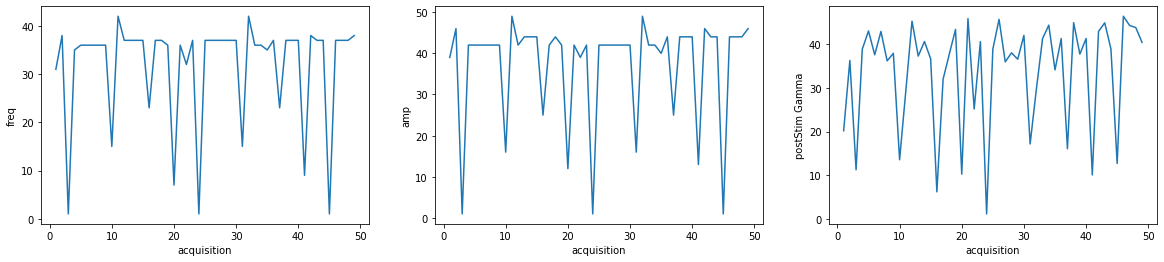

In [37]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")

plt.subplot(1,3,2)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")

plt.subplot(1,3,3)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel_dynamic[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")

 C:\Users\sinad\anaconda3\envs\NeuroGaussianProcess\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22be87fc8b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22be881f850>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22beae6d4c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22beae6da00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x22beae6da30>]}

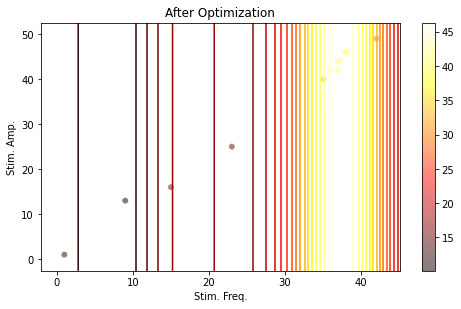

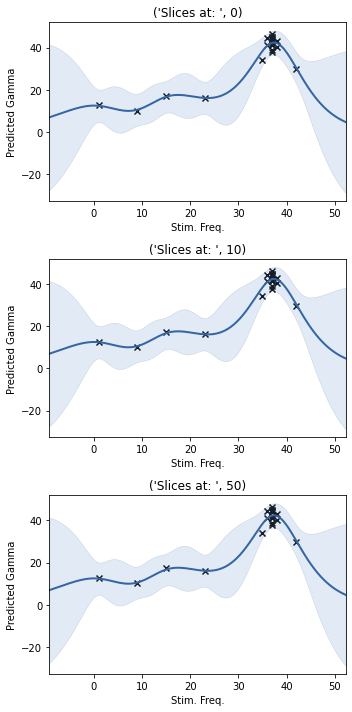

In [38]:
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

### 1.5: comparing static and dynamic BaO

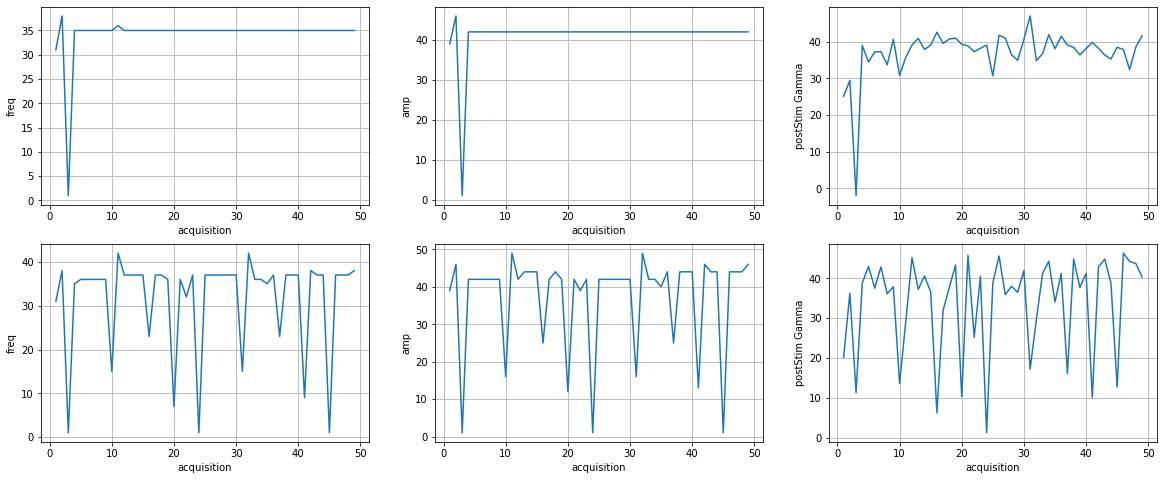

In [39]:
fig = plt.figure(figsize=(20,8));
fig.title = "Static vs. Dynamic BaO"
plt.subplot(2,3,1)
plt.plot(np.arange(1,50), ucb_sample[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(2,3,2)
plt.plot(np.arange(1,50), ucb_sample[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.subplot(2,3,3)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.grid(visible=True)

plt.subplot(2,3,4)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(2,3,5)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.subplot(2,3,6)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel_dynamic[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.grid(visible=True)
plt.show()


x_BaO, y_BaO, trained_model_BaO = model.bayes_opt_update_state(trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, 
                                                               ker_BaO, slice_dim, ylabel, initialize_data_dr_sim)

# initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

### Acquisition Function pseudo code and draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end